<a href="https://colab.research.google.com/github/keiiigo/RecursosOpenSource/blob/main/Capacitated_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import folium
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# Haversine Formula
def haversine(p1, p2):
    R = 6371.0
    lat1, lon1 = p1
    lat2, lon2 = p2
    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    delta_lat = math.radians(lat2 - lat1)
    delta_lon = math.radians(lon2 - lon1)
    a = (math.sin(delta_lat / 2) ** 2 +
         math.cos(lat1_rad) * math.cos(lat2_rad) *
         (math.sin(delta_lon / 2) ** 2))
    c = 2 * math.asin(math.sqrt(a))
    return R * c

In [ ]:
#Capacitated Clustering
def capacitated_clustering(customer_data, vehicle_capacity):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(customer_data[['Latitude', 'Longitude', 'Demand']])

    kmeans = KMeans(init='k-means++', n_init=10, max_iter=300)
    kmeans.fit(X_scaled)

    customer_data['Cluster'] = kmeans.labels_

    cluster_demands = customer_data.groupby('Cluster')['Demand'].sum()

    for cluster, demand in cluster_demands.items():
        if demand > vehicle_capacity:
            print(f"Cluster {cluster} capacity exceeded total demand: {demand}.")

            over_capacity_customers = customer_data[customer_data['Cluster'] == cluster]

            sub_cluster_count = int(demand // vehicle_capacity) + 1

            sub_kmeans = KMeans(n_clusters=sub_cluster_count, init='k-means++', n_init=10, max_iter=300)
            sub_scaled = scaler.fit_transform(over_capacity_customers[['Latitude', 'Longitude', 'Demand']])
            sub_kmeans.fit(sub_scaled)

            max_cluster_id = customer_data['Cluster'].max()
            customer_data.loc[customer_data['Cluster'] == cluster, 'Cluster'] = sub_kmeans.labels_ + max_cluster_id + 1

            print(f"Cluster {cluster} split into {sub_cluster_count} new clusters.")

    return customer_data['Cluster'].values

In [ ]:
# Find Routes
def find_routes(customer_data, vehicle_capacity):
    routes = []
    distances = []
    customers = [[i + 1, row['Customer Name'], row['Latitude'], row['Longitude'], row['Demand']] for i, row in customer_data.iterrows()]
    depot_lat = -25.3775625
    depot_lon = -57.4761875
    labels = capacitated_clustering(customer_data, vehicle_capacity)

    for i in set(labels):
        cluster_customers = [customers[j] for j in range(len(customers)) if labels[j] == i]
        if not cluster_customers:
            continue

        depot_location = (depot_lat, depot_lon)
        route = [("Depot", depot_location)]
        unvisited = cluster_customers[:]
        total_distance = 0

        while unvisited:
            last_visited = route[-1][1]
            nearest = min(unvisited, key=lambda c: haversine(last_visited, (c[2], c[3])))
            route.append((nearest[0], (nearest[2], nearest[3])))
            total_distance += haversine(last_visited, (nearest[2], nearest[3]))
            unvisited.remove(nearest)

        route.append(("Depot", depot_location))
        total_distance += haversine(route[-2][1], depot_location)

        routes.append(route)
        distances.append(total_distance)

    return routes, distances

In [ ]:
# Plot Routes
def plot_routes(customer_data, vehicle_capacity):
    routes, distances = find_routes(customer_data, vehicle_capacity)
    depot_lat = -25.3775625
    depot_lon = -57.4761875
    m = folium.Map(location=[depot_lat, depot_lon], zoom_start=12)

    COLORS = [ "green", "beige", "lightred", "darkgreen", "lightblue", "pink","red", "cadetblue", "purple", "darkred", "orange", "blue", "gray", "darkblue", "darkpurple", "black", "lightgray"]

    for i, route in enumerate(routes):
        cluster_color = COLORS[i % len(COLORS)]

        for j in range(len(route) - 1):
            folium.Marker(
                location=route[j][1],
                popup=f'Stop {j}: {route[j][0]} (Cluster {i})',
                icon=folium.Icon(color=cluster_color)
            ).add_to(m)

        folium.PolyLine([stop[1] for stop in route], color=cluster_color, weight=2.5, opacity=0.8).add_to(m)

    folium.Marker(
        location=[depot_lat, depot_lon],
        popup='Depot',
        icon=folium.Icon(color='black', icon='info-sign')
    ).add_to(m)

    return m

In [ ]:
def plot_clustering_matplotlib(customer_data):
    plt.figure(figsize=(10, 8))

    unique_clusters = customer_data['Cluster'].unique()
    colors = plt.cm.get_cmap('tab20', len(unique_clusters))

    for cluster in unique_clusters:
        cluster_data = customer_data[customer_data['Cluster'] == cluster]
        plt.scatter(
            cluster_data['Longitude'],
            cluster_data['Latitude'],
            label=f"Cluster {cluster}",
            s=cluster_data['Demand'] * 10,
            alpha=0.7
        )

    depot_lat = -25.3775625
    depot_lon = -57.4761875
    plt.scatter(
        depot_lon,
        depot_lat,
        color='black',
        marker='x',
        s=200,
        label='Depot'
    )
    plt.title("Capacitated Clustering of Customers", fontsize=14)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.legend(title="Clusters", loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def main():
    vehicle_capacity = 30
    customer_data = pd.read_csv('clientescor.csv')
    customer_data['Latitude'] = customer_data['Latitude'].astype(float)
    customer_data['Longitude'] = customer_data['Longitude'].astype(float)

    customer_data['Cluster'] = capacitated_clustering(customer_data, vehicle_capacity)

    plot_clustering_matplotlib(customer_data)

    routes, distances = find_routes(customer_data, vehicle_capacity)
    for i, (route, total_distance) in enumerate(zip(routes, distances)):
        print(f"Optimal Route for Cluster {i}:")
        for j, stop in enumerate(route):
            print(f"  Stop {j}: {stop[0]} - Location: {stop[1]}")
        print(f"Total distance: {total_distance:.2f} km\n")

    map_output = plot_routes(customer_data, vehicle_capacity)
    display(map_output)


Cluster 5 capacity exceeded total demand: 40.
Cluster 5 split into 2 new clusters.


<ipython-input-25-d01fcf633531>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_clusters))


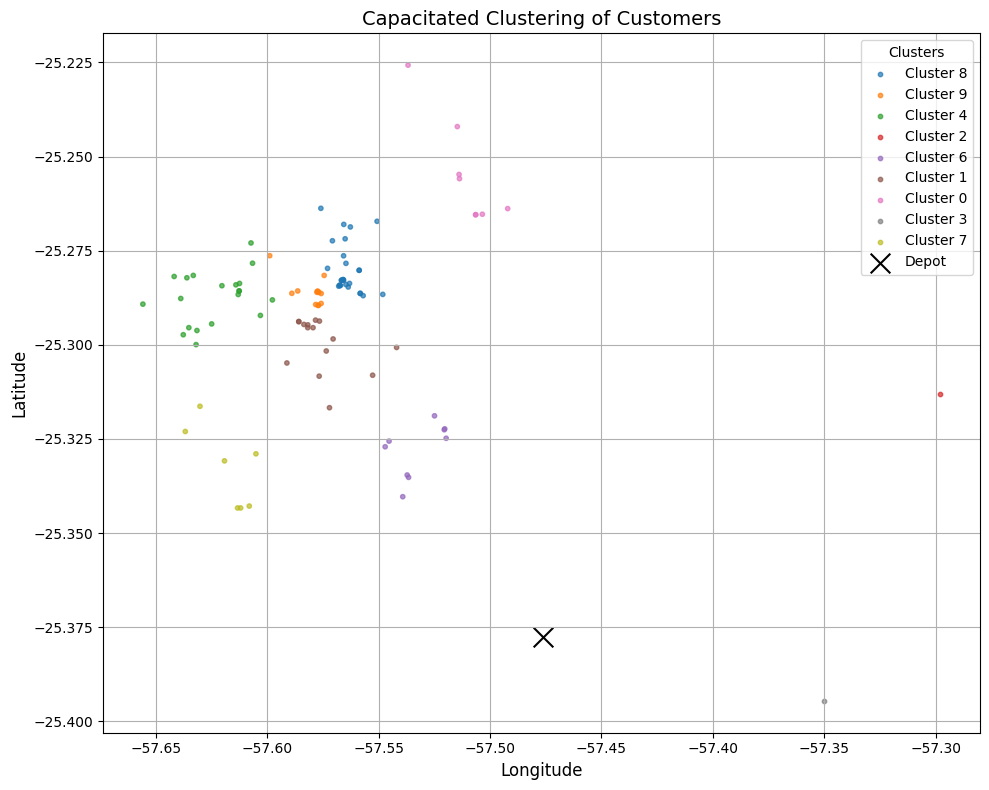

Cluster 6 capacity exceeded total demand: 39.
Cluster 6 split into 2 new clusters.
Optimal Route for Cluster 0:
  Stop 0: Depot - Location: (-25.3775625, -57.4761875)
  Stop 1: 56 - Location: (-25.3006875, -57.5419375)
  Stop 2: 49 - Location: (-25.3080625, -57.5526875)
  Stop 3: 88 - Location: (-25.2984375, -57.5704375)
  Stop 4: 93 - Location: (-25.3016271, -57.5735038)
  Stop 5: 47 - Location: (-25.3083125, -57.5766875)
  Stop 6: 75 - Location: (-25.3166875, -57.5720625)
  Stop 7: 77 - Location: (-25.3048125, -57.5911719)
  Stop 8: 31 - Location: (-25.2938217, -57.5858369)
  Stop 9: 64 - Location: (-25.2938217, -57.5858369)
  Stop 10: 34 - Location: (-25.2945748, -57.5835353)
  Stop 11: 39 - Location: (-25.2946875, -57.5817656)
  Stop 12: 94 - Location: (-25.2954375, -57.5818125)
  Stop 13: 83 - Location: (-25.2954375, -57.5794375)
  Stop 14: 100 - Location: (-25.2934375, -57.5783125)
  Stop 15: 61 - Location: (-25.2936875, -57.5765625)
  Stop 16: Depot - Location: (-25.3775625, -57

In [ ]:
if __name__ == "__main__":
    main()